# Sparking Joy with NLP 
### Distinguishing Posts from the Konmari Subreddit Amongst the Clutter

Using data pulled from Reddit I have built Natural Language Processing (NLP) models to answer the following questions:
* Based on text data from posts, can the model correctly classify posts from [r/konmari](https://www.reddit.com/r/konmari) vs. posts from [r/hoarding](https://www.reddit.com/r/hoarding)?

* Can the model also differentiate [r/konmari](https://www.reddit.com/r/konmari) from a larger set of posts including [r/declutter](https://www.reddit.com/r/declutter) vs. posts from [r/organization](https://www.reddit.com/r/organization)?

* What words are most important in identifying [r/konmari](https://www.reddit.com/r/konmari) posts?

* Are there certain posts with which the model has trouble? Why?

* Can the model be generalized outside [Reddit](https://www.reddit.com/)?

### Package Imports

In [1]:
# Standard DS imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Imports for pulling data
import praw
import requests
import datetime as dt
import time
import keys # My credentials file named keys.py

# NLP feature extraction
import nltk
import regex as re
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

# Display more dataframe rows if necessary
pd.options.display.max_rows = 500
pd.options.display.max_columns = 5_000

# Set random_seed
np.random.seed(14)

# Pulling Data from Reddit

There are numerous ways to pull data from Reddit, including: 
* Straight via [Reddit API](https://www.reddit.com/dev/api/)
* Using [PRAW](https://praw.readthedocs.io/en/latest/), a "Python Reddit API Wrapper", a python package that allows for simple access to Reddit's API 
* Using [Pushshift](https://github.com/pushshift/api) is a big-data storage and analytics project started and maintained by [Jason Baumgartner](reddit.com/u/Stuck_In_the_Matrix).

Mainly for curiousity's sake, I used PRAW to pull a selection of posts, but the Reddit API limits. Additionally, based on a tutorial by Brian Collins, I pulled additional data using the Pushshift API. For each pull of the data I saved the data to a dataframe and exported the dataframe to a csv file for archival. 

## PRAW Script

In [2]:
def get_date(utc):
    '''
    Converts time
    '''
    return dt.date.fromtimestamp(utc)

In [3]:
def drop_duplicates_only_selfposts(df, self_bool='is_self'):
    '''
    Function accepts a dataframe and a specified column
    whose value is boolean.
    Returns df with duplicates removed and removes rows where
    specified column is False.
    '''
    df = df.drop_duplicates()
    df = df.loc[df[self_bool] == True]
    return df

In [4]:
def pull_PRAW(sub_name, sort_type='hot', limit_size=1000, creds=keys):
    '''
    sort_type = ['hot', 'new', 'top']
    top: defaults to alltime 
    
    Function to pull reddit posts using PRAW (Python Reddit API Wrapper)
    Consulted the following articles in the construction of this function:
    https://medium.com/@plog397/webscraping-reddit-python-reddit-api-wrapper-praw-tutorial-for-windows-a9106397d75e
    http://www.storybench.org/how-to-scrape-reddit-with-python/
    '''
    creds.get_token()
    praw_reddit = praw.Reddit(user_agent=creds.info['my_user_agent'],
                              client_id=creds.info['client_id'], 
                              client_secret=creds.info['client_secret'],
                              username=creds.info['my_username'], 
                              password=creds.info['my_password'])
    
    subreddit1 = praw_reddit.subreddit(sub_name)
    
    if sort_type == 'new':
        your_subreddit = subreddit1.new(limit=limit_size)
    elif sort_type == 'top':
        your_subreddit = subreddit1.top(limit=limit_size)
    else:
        your_subreddit = subreddit1.hot(limit=limit_size)
        
    reddict = {"title":[],
               "selftext":[],
               "subreddit":[],
               "created_utc": [],
               "author":[],
               "num_comments":[],
               "score":[],
               "is_self":[],
               "id":[]}

    for submission in your_subreddit:
        reddict["title"].append(submission.title)
        reddict["selftext"].append(submission.selftext)
        reddict['subreddit'].append(submission.subreddit)
        reddict["created_utc"].append(submission.created)
        reddict["num_comments"].append(submission.num_comments)
        reddict["score"].append(submission.score)
        reddict["is_self"].append(submission.is_self)
        reddict["id"].append(submission.id)
        if submission.author == None:
            reddict["author"].append(np.nan)
        else:
            reddict["author"].append(submission.author.name)
        
    reddit_posts = pd.DataFrame(reddict)
    reddit_posts["timestamp"] = reddit_posts["created_utc"].apply(get_date)
    reddit_posts['fulltext'] = reddit_posts['title'] + " " + reddit_posts['selftext']
    
    return drop_duplicates_only_selfposts(reddit_posts)

Here is the pulling procedure for initial posts from r/konmari and r/hoarding via PRAW. <br>
For computational purposes I've saved all data points separately to a csv file as shown below. The rest of notebook runs models off those data points.

In [5]:
# konmari = pull_PRAW('konmari', limit_size=1000)
# hoarding = pull_PRAW('hoarding', limit_size=1000)

## Pushshift Script

See Reddit Push_shift_API.ipynb

In [6]:
def query_pushshift(subreddit, kind='submission', skip=1, times=10, size=1000,
                    subfield = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 
                                'score', 'is_self','id'],
                    comfields = ['body', 'score', 'created_utc']):
    
    '''
    Function substantially provided by Brian Collins during General Assembly DSI lessons with some customizations
    Queries pushshift API (https://pushshift.io) for submissions from subreddit specified

    '''

    stem = f'https://api.pushshift.io/reddit/search/{kind}/?subreddit={subreddit}&size={size}'
    mylist = []
    
    for x in range(1, times):
        URL = "{}&after={}d".format(stem, skip * x)
        print(URL)
        response = requests.get(URL)
        assert response.status_code == 200
        mine = response.json()['data']
        df = pd.DataFrame.from_dict(mine)
        mylist.append(df)
        time.sleep(2)
        
    full = pd.concat(mylist, sort=False)
    
    if kind == "submission":
        full = full[subfield]
        full = drop_duplicates_only_selfposts(full)
     
    full['timestamp'] = full["created_utc"].apply(get_date)
    full['fulltext'] = full['title'] + " " + full['selftext']

    print(f'The size of your data is {full.shape}.')
    return full 

Here is the pulling procedure for initial posts from r/konmari and r/hoarding via the Pushshift API. <br>
For computational purposes I've saved all data points separately to a csv file as shown below. The rest of notebook runs models off those data points.

In [7]:
# hoarding_and_konmari = query_pushshift('konmari',skip=7,times=104).append(query_pushshift('hoarding',skip=7,times=104))

## Pulling in, Combining, and Cleaning Data

More explanation TK

In [8]:
def read_and_clean(data_file, target_sub, filetype='csv'):
    '''
    target_sub is name of subreddit you want to identify posts from
    Function reads in data as .csv or dataframe and cleans for binary
    classification of target_sub
    '''
    if filetype == 'df':
        df = data_file
    else:
        df = pd.read_csv(data_file,index_col='Unnamed: 0')
        
    df.dropna(subset=['selftext'], inplace=True) # There should be none of these given the p
    df[target_sub] = df['subreddit'].map(lambda x: 1 if x==target_sub else 0)
    df.reset_index(inplace=True,drop=True)
    return df

In [9]:
def combine_files(file_list, target_sub, filetype='csv'):
    '''
    Combines files into one dataframe
    (includes read_and_clean features)
    '''
    appended_list=[]
    for file in file_list:
        df = read_and_clean(file, target_sub, filetype=filetype)
        appended_list.append(df)
    combined_df = pd.concat(appended_list,ignore_index=True)
    combined_df =  combined_df.drop_duplicates()
    return combined_df

The below cell cleans and combines the data pulled below and exports to a csv file. <br>
The rest of the notebook works off the data reimported below. 

In [10]:
# post_files = [konmari, hoarding, hoarding_and_konmari]
# reddit = combine_files(post_files, target_sub='konmari',filetype='df')
# reddit.to_csv('./datasets/reddit-3-Apr-2019.csv', index=False)

In [11]:
# Read in data previously archived
reddit = pd.read_csv('./datasets/reddit-3-Apr-2019.csv')

In [12]:
# Checking the distribution of posts by subreddit
reddit['konmari'].value_counts(normalize=True)

1    0.530485
0    0.469515
Name: konmari, dtype: float64

In [13]:
# Checking size of dataset
reddit.shape 

(4986, 12)

The dataset is pretty balanced with 4,986 observations, 53% of which are from r/konmari and 47% of which are from r/hoarding.

In [14]:
# Inspecting initial observations
reddit.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,id,timestamp,fulltext,konmari
0,50k! Wow!,"Exactly a month ago, we were at 40k subscriber...",konmari,1.549652e+09,adagiosummoner,8,136,True,aojoye,2019-02-08,"50k! Wow! Exactly a month ago, we were at 40k ...",1
1,Storage issues... help?,Im currently going through all my clothes and ...,konmari,1.554318e+09,CakeofRage,7,6,True,b922ni,2019-04-03,Storage issues... help? Im currently going thr...,1
2,Finding quiet space,I do not know what to do about finding a quiet...,konmari,1.554322e+09,ashes1436,2,1,True,b93014,2019-04-03,Finding quiet space I do not know what to do a...,1
3,When I find myself thinking what if I need thi...,NaN,konmari,1.554216e+09,havingarecky,7,38,True,b8k10n,2019-04-02,When I find myself thinking what if I need thi...,1
4,My favourite top has gone missing and I'm kind...,The kon mari method helped me make a wardrobe ...,konmari,1.554246e+09,Bluebucketandspade35,15,7,True,b8q5zu,2019-04-02,My favourite top has gone missing and I'm kind...,1


In [15]:
# Instatiate tokenizer, lemmatizer, define function to do both
# Credit to titipata on StackOverflow for simplification https://bit.ly/2FK3otO
ws_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatize_text(text):
    lemma_list = [lemmatizer.lemmatize(w) for w in ws_tokenizer.tokenize(text)]
    return " ".join(lemma_list)

def stem_text(text):
    stem_list = [stemmer.stem(w) for w in ws_tokenizer.tokenize(text)]
    return " ".join(stem_list)

In [16]:
def clean_lemma_df_col(df, col):
    '''
    First removes non-numeric characters from df column then
    performs lemmatization to certain column in dataframe
    '''
    df[col] = df[col].map(lambda x: re.sub("[^a-zA-Z]+"," ", x))
    df['text_lemmatized'] = df[col].apply(lemmatize_text)
    return df

In [17]:
def clean_stem_df_col(df, col):
    '''
    First removes non-numeric characters from df column then
    performs stemming to certain column in dataframe
    '''
    df[col] = df[col].map(lambda x: re.sub("[^a-zA-Z]+"," ", x))
    df['text_stemmed'] = df[col].apply(stem_text)
    return df

In [18]:
# Created copies of the dataframe with stemming and lematization for future use
reddit_lemma = clean_lemma_df_col(reddit,'fulltext')
reddit_stem = clean_stem_df_col(reddit,'fulltext')

### Setting our Variables 

In [19]:
X = reddit['fulltext'] # concatination of title text and selftext (post text)
y = reddit['konmari']

In [20]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### Naive Bayes

In [21]:
# Instiating Multinomial Naive Bayes Model
nb = MultinomialNB()

In [22]:
# Setting up pipeline with TFIDF and Naive Bayes
pipe_naive_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [23]:
# Grid search parameters
params_nb = {
    'tfidf__max_features': [100000, 50000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__stop_words': ['english', None],
    'nb__alpha': [.5, 1, 10, 100]
}

In [24]:
# Instantiate and fit GridSearch on pipeline with TFIDF and Naive Bayes
grid_nb = GridSearchCV(pipe_naive_tf, params_nb, cv=3, n_jobs=-1)
grid_nb.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tfidf__max_features': [100000, 50000], 'tfidf__ngram_range': [(1, 1), (1, 2)], 'tfidf__stop_words': ['english', None], 'nb__alpha': [0.5, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
with open('./pickled-models/sparkingjoy-model-nb.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(grid_nb, f, pickle.HIGHEST_PROTOCOL)

In [26]:
print(f"The best parameters are: {grid_nb.best_params_}")
print(f"The best cross-val score is: {grid_nb.best_score_:.4f}")

The best parameters are: {'nb__alpha': 0.5, 'tfidf__max_features': 100000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}
The best cross-val score is: 0.9484


In [27]:
len(grid_nb.best_estimator_.named_steps.tfidf.get_feature_names())

100000

In [28]:
print(f"The training score for the best parameters is: {grid_nb.score(X_train, y_train):.4f}")

The training score for the best parameters is: 0.9917


In [29]:
print(f"The test score for best parameters is: {grid_nb.score(X_test, y_test):.4f}")

The test score for best parameters is: 0.9527


In [30]:
y_train_hat_grid = grid_nb.predict(X_train)
y_test_hat_grid = grid_nb.predict(X_test)

print(f'Confusion matrix for training data:\n {confusion_matrix(y_train, y_train_hat_grid)}')
print(f'Confusion matrix for testing data:\n {confusion_matrix(y_test, y_test_hat_grid)}')

Confusion matrix for training data:
 [[1731   25]
 [   6 1977]]
Confusion matrix for testing data:
 [[551  34]
 [ 25 637]]


### Logistic Regression

In [31]:
pipe_lr_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

In [32]:
# Grid search parameters
params_lr = {
    'tfidf__max_features': [50000, 20000, None],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__stop_words': ['english'],
    'logreg__C': [.1, .5, 1, 10],
    'logreg__penalty': ['l1','l2']
}

In [33]:
# Instantiate and fit GridSearch on pipeline with TFIDF and Naive Bayes
grid_lr = GridSearchCV(pipe_lr_tf, params_lr, cv=3, verbose=1,n_jobs=-1)
grid_lr.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   45.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tfidf__max_features': [50000, 20000, None], 'tfidf__ngram_range': [(1, 1), (1, 2)], 'tfidf__stop_words': ['english'], 'logreg__C': [0.1, 0.5, 1, 10], 'logreg__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [34]:
with open('./pickled-models/sparkingjoy-model-logreg.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(grid_lr, f, pickle.HIGHEST_PROTOCOL)

In [35]:
print(f"The best parameters are: {grid_lr.best_params_}")
print(f"The best cross-val score is: {grid_lr.best_score_:.4f}")

The best parameters are: {'logreg__C': 10, 'logreg__penalty': 'l2', 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}
The best cross-val score is: 0.9596


In [36]:
print(f"The training score for the best parameters is: {grid_lr.score(X_train, y_train):.4f}")
print(f"The test score for best parameters is: {grid_lr.score(X_test, y_test):.4f}")

The training score for the best parameters is: 0.9989
The test score for best parameters is: 0.9575


In [37]:
y_train_hat_grid = grid_lr.predict(X_train)
y_test_hat_grid = grid_lr.predict(X_test)

print(f'Confusion matrix for training data:\n {confusion_matrix(y_train, y_train_hat_grid)}')
print(f'Confusion matrix for testing data:\n {confusion_matrix(y_test, y_test_hat_grid)}')

Confusion matrix for training data:
 [[1754    2]
 [   2 1981]]
Confusion matrix for testing data:
 [[559  26]
 [ 27 635]]


In [38]:
# Isolating out the false negatives, false positives
fn_train = [i for i in X_train[(y_train == 1) & (y_train_hat_grid[:].T == 0)]]
fp_train = [i for i in X_train[(y_train == 0) & (y_train_hat_grid[:].T == 1)]]
fn_test = [i for i in X_test[(y_test == 1) & (y_test_hat_grid[:].T == 0)]]
fp_test = [i for i in X_test[(y_test == 0) & (y_test_hat_grid[:].T == 1)]]

In [39]:
# Print the first (and only) false negatives on training data
print(fn_train[0])

Someone told me to post this here I m a hoarder looking for help I m sure most would call me a hoarder so let s get into it I m so the toys and vhs tapes are old as me Ive already got rid of bags of clothes But do i still have too much My dad died when i was young he gifted me many things before he passed I find it hard to get rid of the things because there memories and other reasons I have no friends who want to help so reddit is my source of advice Where do i start Here s pics of the mess http i imgur com qS jS jpg http i imgur com x Z Kn jpg


Searching Reddit it turns out that the post was cross-posted to [r/ICleanedMyRoom](https://www.reddit.com/r/ICleanedMyRoom), [r/declutter](https://www.reddit.com/r/declutter), [r/konmari](https://www.reddit.com/r/konmari), [r/ChildofHoarder](https://www.reddit.com/r/ChildofHoarder), and [r/hoarding](https://www.reddit.com/r/hoarding) and it just so happens that the training data had r/konmari version. 

### Examining most important words

In [40]:
logreg_coef = dict(zip(grid_lr.best_estimator_.named_steps.tfidf.get_feature_names(), 
                       grid_lr.best_estimator_.named_steps.logreg.coef_[0]))

In [41]:
# Find most valuable columns
max_absvalue = 0
max_value = 0
for i in logreg_coef.values():
    if np.abs(i) > max_value:
        max_absvalue = np.abs(i)
        max_value = i

for name, coef in logreg_coef.items():
    if coef == max_value:
        print(name)

konmari


In [42]:
coefs_df = pd.DataFrame(logreg_coef,index=[0])

In [43]:
top_kmari_coefs = coefs_df.loc[0][coefs_df.loc[0] > 1].sort_values(ascending=False)[:20]

In [44]:
top_hoard_coefs = coefs_df.loc[0][coefs_df.loc[0] < -1].sort_values(ascending=True)[:20]

In [45]:
np.round(np.exp(coefs_df['konmari'])[0],2)

7667387.0

The word 'Konmari' is a dead giveaway (obviously)!

#### Visualization of most important words

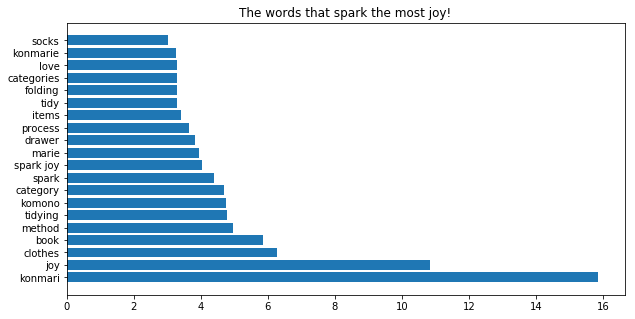

In [46]:
plt.figure(figsize=(10,5))
plt.title("The words that spark the most joy!")
plt.barh(top_kmari_coefs.index,top_kmari_coefs.values);

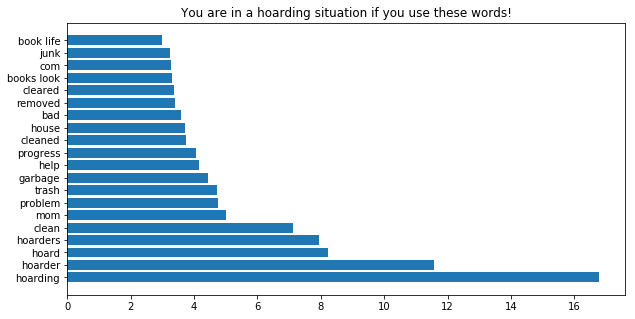

In [47]:
plt.figure(figsize=(10,5))
plt.title("You are in a hoarding situation if you use these words!")
plt.barh(top_hoard_coefs.index, -1 * top_hoard_coefs.values);

### Voting Classifier

In [48]:
pipe_vc = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2),stop_words='english', max_features = 20000)),
    ('vc', VotingClassifier([
        ('rfc', RandomForestClassifier(n_estimators=100)),
        ('abc', AdaBoostClassifier()),
        ('gbc', GradientBoostingClassifier()),
        ('lr', LogisticRegression(solver='liblinear',C=10,penalty='l2'))],
        voting='soft'))
])

In [49]:
pipe_vc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True...0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None))])

In [50]:
with open('./pickled-models/sparkingjoy-model-vc.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(pipe_vc, f, pickle.HIGHEST_PROTOCOL)

In [51]:
print(f"The training score for the best parameters is: {pipe_vc.score(X_train, y_train):.4f}")
print(f"The test score for best parameters is: {pipe_vc.score(X_test, y_test):.4f}")

The training score for the best parameters is: 0.9995
The test score for best parameters is: 0.9567


In [52]:
y_train_hat_grid = pipe_vc.predict(X_train)
y_test_hat_grid = pipe_vc.predict(X_test)

print(f'Confusion matrix for training data:\n {confusion_matrix(y_train, y_train_hat_grid)}')
print(f'Confusion matrix for testing data:\n {confusion_matrix(y_test, y_test_hat_grid)}')

Confusion matrix for training data:
 [[1755    1]
 [   1 1982]]
Confusion matrix for testing data:
 [[547  38]
 [ 16 646]]


### Add more similar subreddits into negative class (r/declutter and r/organization)

The below cell shows the code used to pull additional data from r/declutter and r/organization.

In [53]:
# tidy = query_pushshift('declutter',skip=7,times=52).append(query_pushshift('organization',skip=7,times=52))
# tidy = combine_files([tidy], target_sub='konmari',filetype='df')
# tidy.to_csv('./datasets/declutter-and-org.csv',index=False)

In [54]:
tidy = pd.read_csv('./datasets/declutter-and-org.csv')
reddit_incl_tidy = reddit.append(tidy,ignore_index=True)
reddit_incl_tidy.drop_duplicates(inplace=True)
reddit_incl_tidy.drop(columns=['text_lemmatized','text_stemmed'],inplace=True)
reddit_incl_tidy.dropna(inplace=True)

reddit_incl_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6359 entries, 0 to 6616
Data columns (total 12 columns):
author          6359 non-null object
created_utc     6359 non-null float64
fulltext        6359 non-null object
id              6359 non-null object
is_self         6359 non-null bool
konmari         6359 non-null int64
num_comments    6359 non-null int64
score           6359 non-null int64
selftext        6359 non-null object
subreddit       6359 non-null object
timestamp       6359 non-null object
title           6359 non-null object
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 602.4+ KB


/Users/willkarnasiewicz/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [55]:
reddit_incl_tidy['konmari'].value_counts(normalize=True)

0    0.59805
1    0.40195
Name: konmari, dtype: float64

Now the data is more shifted towards the negative class but still fairly balanced.

In [56]:
X = reddit_incl_tidy['fulltext']
y = reddit_incl_tidy['konmari']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [58]:
grid_lr.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   53.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tfidf__max_features': [50000, 20000, None], 'tfidf__ngram_range': [(1, 1), (1, 2)], 'tfidf__stop_words': ['english'], 'logreg__C': [0.1, 0.5, 1, 10], 'logreg__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [59]:
print(f"The best parameters are: {grid_lr.best_params_}")

The best parameters are: {'logreg__C': 10, 'logreg__penalty': 'l2', 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}


In [60]:
print(f"The training score for the best parameters is: {grid_lr.score(X_train, y_train):.4f}")
print(f"The test score for best parameters is: {grid_lr.score(X_test, y_test):.4f}")

The training score for the best parameters is: 0.9994
The test score for best parameters is: 0.9000


In [61]:
y_train_hat_grid = grid_lr.predict(X_train)
y_test_hat_grid = grid_lr.predict(X_test)

print(f'Confusion matrix for training data:\n {confusion_matrix(y_train, y_train_hat_grid)}')
print(f'Confusion matrix for testing data:\n {confusion_matrix(y_test, y_test_hat_grid)}')

Confusion matrix for training data:
 [[2851    1]
 [   2 1915]]
Confusion matrix for testing data:
 [[893  58]
 [101 538]]


In [62]:
# Isolating out the false negatives and positives
fn_train = [i for i in X_train[(y_train == 1) & (y_train_hat_grid[:].T == 0)]]
fn_test = [i for i in X_test[(y_test == 1) & (y_test_hat_grid[:].T == 0)]]
fp_train = [i for i in X_train[(y_train == 0) & (y_train_hat_grid[:].T == 1)]]
fp_test = [i for i in X_test[(y_test == 0) & (y_test_hat_grid[:].T == 1)]]

## Does stemming or lemmatizing matter? (with original dataset)

### Stemming

In [63]:
X = reddit['text_stemmed']
y = reddit['konmari']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [64]:
grid_lr_stem = GridSearchCV(pipe_lr_tf, params_lr, cv=3, n_jobs=-1)
grid_lr_stem.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tfidf__max_features': [50000, 20000, None], 'tfidf__ngram_range': [(1, 1), (1, 2)], 'tfidf__stop_words': ['english'], 'logreg__C': [0.1, 0.5, 1, 10], 'logreg__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [65]:
print(f"The best parameters are: {grid_lr_stem.best_params_}")
print(f"The best cross-val score is: {grid_lr_stem.best_score_:.4f}")

The best parameters are: {'logreg__C': 10, 'logreg__penalty': 'l2', 'tfidf__max_features': 50000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}
The best cross-val score is: 0.9548


In [66]:
print(f"The training score for the best parameters is: {grid_lr_stem.score(X_train, y_train):.4f}")
print(f"The test score for best parameters is: {grid_lr_stem.score(X_test, y_test):.4f}")

The training score for the best parameters is: 0.9989
The test score for best parameters is: 0.9671


In [67]:
y_train_hat_grid = grid_lr_stem.predict(X_train)
y_test_hat_grid = grid_lr_stem.predict(X_test)

print(f'Confusion matrix for training data:\n {confusion_matrix(y_train, y_train_hat_grid)}')
print(f'Confusion matrix for testing data:\n {confusion_matrix(y_test, y_test_hat_grid)}')

Confusion matrix for training data:
 [[1754    2]
 [   2 1981]]
Confusion matrix for testing data:
 [[566  19]
 [ 22 640]]


In [68]:
stem_coef = dict(zip(grid_lr.best_estimator_.named_steps.tfidf.get_feature_names(), 
                       grid_lr.best_estimator_.named_steps.logreg.coef_[0]))

In [69]:
coefs_df = pd.DataFrame(stem_coef,index=[0])
top_konmari_stems = coefs_df.loc[0][coefs_df.loc[0] > 1].sort_values(ascending=False)[:20]
top_non_konmari_stems = coefs_df.loc[0][coefs_df.loc[0] < -1].sort_values(ascending=True)[:20]

### Lemmatization

In [70]:
X = reddit['text_lemmatized']
y = reddit['konmari']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [71]:
grid_lr_lemma = GridSearchCV(pipe_lr_tf, params_lr, cv=3, n_jobs=-1)
grid_lr_lemma.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tfidf__max_features': [50000, 20000, None], 'tfidf__ngram_range': [(1, 1), (1, 2)], 'tfidf__stop_words': ['english'], 'logreg__C': [0.1, 0.5, 1, 10], 'logreg__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [72]:
print(f"The best parameters are: {grid_lr_lemma.best_params_}")
print(f"The best cross-val score is: {grid_lr_lemma.best_score_:.4f}")

The best parameters are: {'logreg__C': 10, 'logreg__penalty': 'l2', 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}
The best cross-val score is: 0.9580


In [73]:
print(f"The training score for the best parameters is: {grid_lr_lemma.score(X_train, y_train):.4f}")
print(f"The test score for best parameters is: {grid_lr_lemma.score(X_test, y_test):.4f}")

The training score for the best parameters is: 0.9995
The test score for best parameters is: 0.9511


In [74]:
y_train_hat_grid = grid_lr_lemma.predict(X_train)
y_test_hat_grid = grid_lr_lemma.predict(X_test)

print(f'Confusion matrix for training data:\n {confusion_matrix(y_train, y_train_hat_grid)}')
print(f'Confusion matrix for testing data:\n {confusion_matrix(y_test, y_test_hat_grid)}')

Confusion matrix for training data:
 [[1755    1]
 [   1 1982]]
Confusion matrix for testing data:
 [[562  23]
 [ 38 624]]


In [75]:
lemma_coef = dict(zip(grid_lr_lemma.best_estimator_.named_steps.tfidf.get_feature_names(), 
                       grid_lr.best_estimator_.named_steps.logreg.coef_[0]))

In [76]:
coefs_df = pd.DataFrame(lemma_coef,index=[0])
top_konmari_lemma = coefs_df.loc[0][coefs_df.loc[0] > 1].sort_values(ascending=False)[:20]
top_non_konmari_lemma = coefs_df.loc[0][coefs_df.loc[0] < -1].sort_values(ascending=True)[:20]

## Further Analysis


### Testing with Netflix Show Transcripts

In [77]:
kondo = pd.read_csv('./datasets/netflix-konmari-text.csv')
kondo['text'] = kondo['text'].map(lambda x: re.sub("[^a-zA-Z]+"," ", x))

In [78]:
pipe_vc.predict(kondo['text'])

array([1, 1, 1, 1, 1, 1, 1, 1])

In [79]:
all_probs = pipe_vc.predict_proba(kondo['text']).ravel()
konmari_probs = []
for i in range(len(all_probs)):
    if i % 2 == 1:
        konmari_probs.append(all_probs[i])
episode = list(range(1,9))

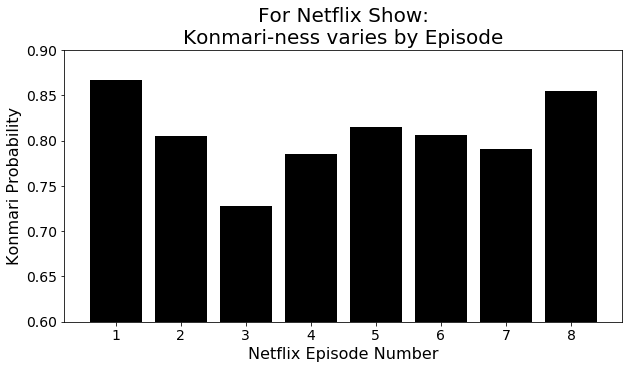

In [80]:
plt.figure(figsize=(10,5))
plt.bar(x=episode,height=konmari_probs,color='k')
plt.xlabel('Netflix Episode Number',fontsize=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel('Konmari Probability',fontsize=16)
plt.ylim(.6, .9)  
plt.title('For Netflix Show:\nKonmari-ness varies by Episode',fontsize=20);

The first episode was the most clearly r/konmari style! But all episodes were correctly identified as Marie Kondo!

### How does the model perform once you remove variants of subreddit names?

In [81]:
# Removing konmari and hoarding variations from the corpus
reddit['fulltext'] = reddit['fulltext'].map(lambda x: re.sub("[Kk][Oo][Nn][Mm][Aa][Rr][Ii]\w*"," ", x))
reddit['fulltext'] = reddit['fulltext'].map(lambda x: re.sub("[Hh][Oo][Aa][Rr][Dd][A-Za-z]*\w*"," ", x))

In [82]:
reddit.head();

In [83]:
X = reddit['fulltext']
y = reddit['konmari']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [85]:
# Instantiate and fit GridSearch on pipeline with TFIDF and Naive Bayes
grid_lr_notitles = GridSearchCV(pipe_lr_tf, params_lr, cv=3, n_jobs=-1)
grid_lr_notitles.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tfidf__max_features': [50000, 20000, None], 'tfidf__ngram_range': [(1, 1), (1, 2)], 'tfidf__stop_words': ['english'], 'logreg__C': [0.1, 0.5, 1, 10], 'logreg__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [86]:
print(f"The best parameters are: {grid_lr_notitles.best_params_}")
print(f"The best cross-val score is: {grid_lr_notitles.best_score_:.4f}")

The best parameters are: {'logreg__C': 10, 'logreg__penalty': 'l2', 'tfidf__max_features': 50000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}
The best cross-val score is: 0.9321


In [87]:
print(f"The training score for the best parameters is: {grid_lr_notitles.score(X_train, y_train):.4f}")
print(f"The test score for best parameters is: {grid_lr_notitles.score(X_test, y_test):.4f}")

The training score for the best parameters is: 0.9989
The test score for best parameters is: 0.9399


In [88]:
y_train_hat_grid = grid_lr_notitles.predict(X_train)
y_test_hat_grid = grid_lr_notitles.predict(X_test)

print(f'Confusion matrix for training data:\n {confusion_matrix(y_train, y_train_hat_grid)}')
print(f'Confusion matrix for testing data:\n {confusion_matrix(y_test, y_test_hat_grid)}')

Confusion matrix for training data:
 [[1753    3]
 [   1 1982]]
Confusion matrix for testing data:
 [[556  29]
 [ 46 616]]


In [89]:
# Isolating out the false negatives
fn_train = [i for i in X_train[(y_train == 1) & (y_train_hat_grid[:].T == 0)]]
fn_test = [i for i in X_test[(y_test == 1) & (y_test_hat_grid[:].T == 0)]]

In [90]:
# Print the first false positives on training data
print(fp_train[0])

\ The Life Changing Magic of Tidying up | Quick Insights /   

My apartment used to be a Mess!.. :(  

Full of things I never used and that didn't make me Happy!

So I used the Konmari method, that I learned from the Book: "The life changing magic of tidying up" by Marie Kondó.

**Here's my summary of the book**:

[https://www.youtube.com/watch?v=Dxyec4q3K-M](https://www.youtube.com/watch?v=Dxyec4q3K-M)

in the book "The life changing magic of tidying up", Mare Kondó says:

*"If you use the right method and concentrate your efforts on eliminating clutter thoroughly and completely within a short span of time, you’ll see instant results that will empower you to keep your space in order ever after"*

Now let's get straigt to the method:

**Step 1: Question why you want to tidy.**

Step one is to question why you want to tidy, and then question the answer you give and then question the next answer and so on, until you arrive at the underlying reason, which is that you want to be happy. Thi

In [91]:
notitles_coef = dict(zip(grid_lr_notitles.best_estimator_.named_steps.tfidf.get_feature_names(), 
                       grid_lr_notitles.best_estimator_.named_steps.logreg.coef_[0]))

In [92]:
coefs_df = pd.DataFrame(notitles_coef,index=[0])

In [93]:
konmariwords = list(coefs_df.loc[0][coefs_df.loc[0] > 1].sort_values(ascending=False)[:20].index)
konmariwords

['joy',
 'method',
 'book',
 'clothes',
 'komono',
 'tidying',
 'process',
 'category',
 'spark',
 'ing',
 'tidy',
 'spark joy',
 'drawer',
 'categories',
 'marie',
 'ideas',
 'papers',
 'netflix',
 'folding',
 'books']

In [94]:
hoardingwords = list(coefs_df.loc[0][coefs_df.loc[0] < -1].sort_values(ascending=True)[:20].index)
hoardingwords

['clean',
 'problem',
 'help',
 'mom',
 'trash',
 'house',
 'progress',
 'bad',
 'garbage',
 'disorder',
 'junk',
 'cleaned',
 'stuff',
 'worse',
 'story',
 'health',
 'parents',
 'tendencies',
 'living',
 'dad']

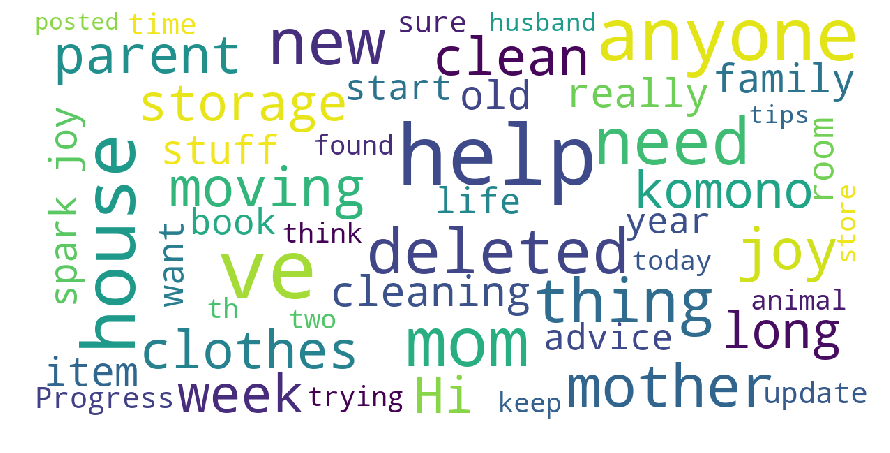

In [95]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=3,
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(reddit['fulltext'])

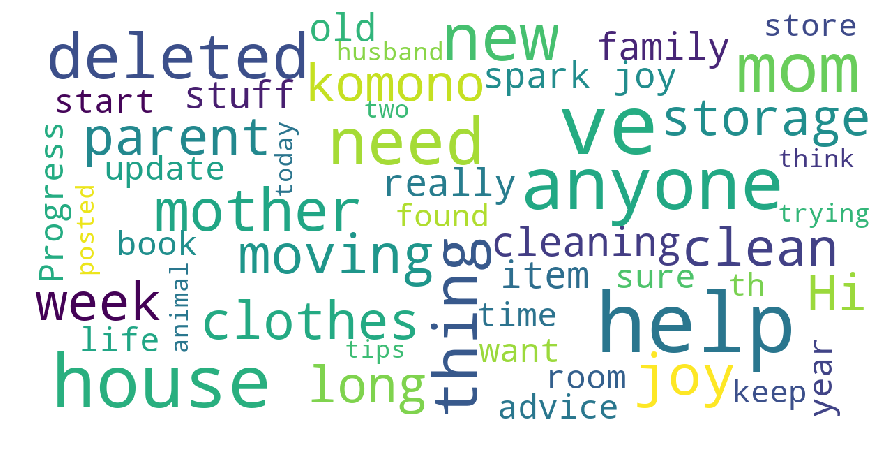

In [96]:
show_wordcloud(reddit['fulltext'])

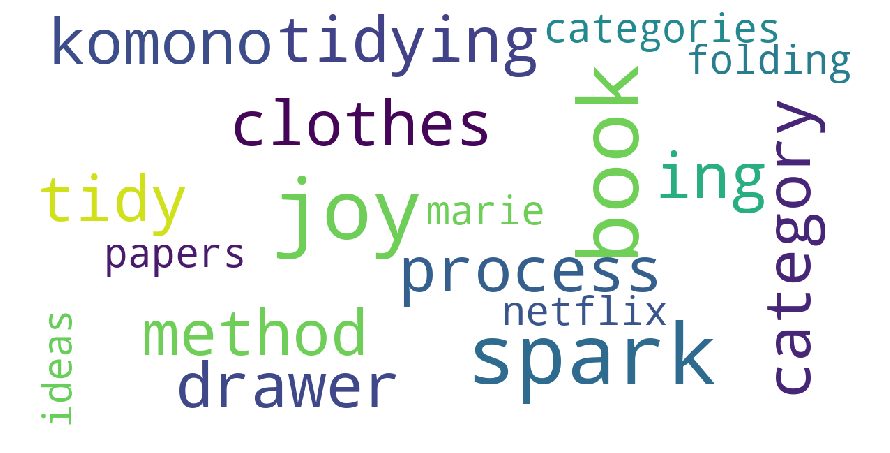

In [97]:
df_kon_coef = pd.DataFrame(konmariwords)
show_wordcloud(df_kon_coef)

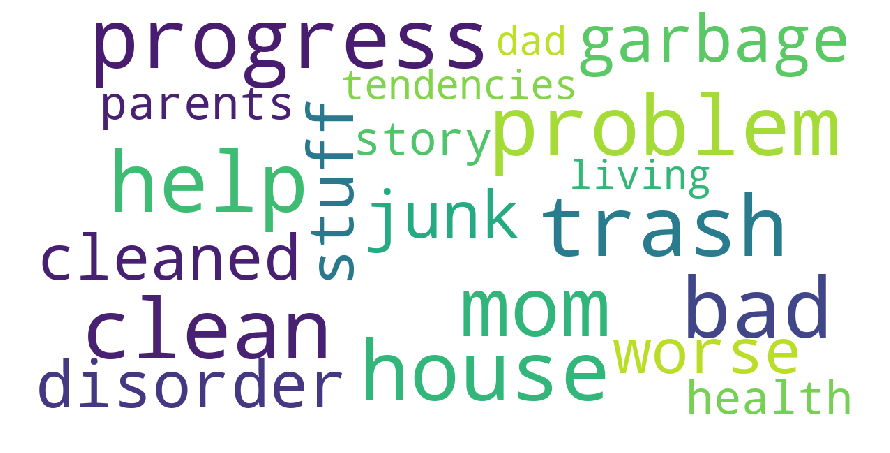

In [98]:
df_hoard_coef = pd.DataFrame(hoardingwords)
show_wordcloud(df_hoard_coef)

## Conclusions

The NLP models that sought to classify r/hoarding and r/konmari, all showed strong results with testing scores (r-squared) of 0.95 or higher.

Once other similarly 'tidy' subreddits were introduced, accuracy scores dropped and overfitting increased, as the new posts were much more similar to the positive target than the existing observations of the negative target class.

Stemming and lemmatization was performed and although not dramatically different than the base models, lemmatization might be performed due to a slight reduction in variance.

A further analysis was performed by taking transcripts of the Marie Kondo's Netflix show (scraped from https://www.springfieldspringfield.co.uk) and feeding each episode into an existing base NLP model. Interestingly, each episode of the show had differing 'levels of Konmari-ness' and each were correctly identified as being a part of the 'konmari' class.

## Further Improvements
In order to cut down on the variance, I would like to gather additional data to feed into the model. Additionally, given the interesting results with the Netflix transcripts, I'd like to test the improved model on additional non-reddit data for a more generalized model of 'Konmari-ness'.